In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass
password = getpass.getpass()

········


In [4]:
connection_string = "mysql+pymysql://root:" + password + '@localhost/bank'
engine = create_engine(connection_string)

query = """
SELECT 
    t.type,
    t.operation,
    t.amount AS t_amount,
    t.balance,
    t.k_symbol,
    l.amount AS l_amount,
    l.duration,
    l.payments,
    l.status
FROM
    trans t
        LEFT JOIN
    loan l ON t.account_id = l.account_id;
"""

In [84]:
data = pd.read_sql_query(query, engine)

In [85]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,VKLAD,700.0,700.0,,NaN,NaN,NaN,None
1,PRIJEM,VKLAD,900.0,900.0,,NaN,NaN,NaN,None
2,PRIJEM,VKLAD,1000.0,1000.0,,NaN,NaN,NaN,None
3,PRIJEM,VKLAD,600.0,600.0,,NaN,NaN,NaN,None
4,PRIJEM,VKLAD,400.0,400.0,,NaN,NaN,NaN,None


In [86]:
data.isna().sum()

type              0
operation         0
t_amount          0
balance           0
k_symbol          0
l_amount     711938
duration     711938
payments     711938
status       711938
dtype: int64

In [87]:
len(data)

868019

In [88]:
# filter all the NaN
data = data[~data['duration'].isna()]

In [89]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156081 entries, 62 to 868011
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   type       156081 non-null  object 
 1   operation  156081 non-null  object 
 2   t_amount   156081 non-null  float64
 3   balance    156081 non-null  float64
 4   k_symbol   156081 non-null  object 
 5   l_amount   156081 non-null  float64
 6   duration   156081 non-null  float64
 7   payments   156081 non-null  float64
 8   status     156081 non-null  object 
dtypes: float64(5), object(4)
memory usage: 11.9+ MB


In [91]:
# turning duration into categorical, becaus it comes in values of whole years (1,2,3,4,5)
data['duration'] = data['duration'].astype('object')

### cleaning categoricals

In [92]:
data['operation'].value_counts()

VYBER             70189
                  31337
PREVOD NA UCET    25796
VKLAD             22633
PREVOD Z UCTU      5336
VYBER KARTOU        790
Name: operation, dtype: int64

In [93]:
def clean_operation(x):
    x = x.lower()
    if 'vyber' in x:
        return 'vyber'
    elif 'prevod' in x:
        return 'prevod'
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

In [94]:
data['operation'] = data['operation'].apply(clean_operation)

In [95]:
data['k_symbol'].value_counts().index

Index(['', 'UROK', 'SLUZBY', 'SIPO', 'UVER', ' ', 'POJISTNE', 'SANKC. UROK'], dtype='object')

In [96]:
def clean_ksymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

In [97]:
data['k_symbol'] = data['k_symbol'].apply(clean_ksymbol)

In [98]:
data['k_symbol'].value_counts()

unknown        79925
UROK           31337
SLUZBY         23592
SIPO           10482
UVER            7744
POJISTNE        2412
SANKC. UROK      589
Name: k_symbol, dtype: int64

In [99]:
# filter data so that k_symbol is cleaned of 'POJISTINE', 'SANKC. UROK' or 'UVER'
data = data[~data['k_symbol'].isin(['POJISTINE', 'SANKC. UROK', 'UVER'])]

In [100]:
def clean_type(x):
    if 'PRI' in x:
        return 'PRIJEM'
    else:
        return x
    
data['type'] = data['type'].apply(clean_type)

In [101]:
data['type'].value_counts()

VYDAJ     83095
PRIJEM    59306
VYBER      5347
Name: type, dtype: int64

### check correlations for numerical columns

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
corr_matrix = data.corr()

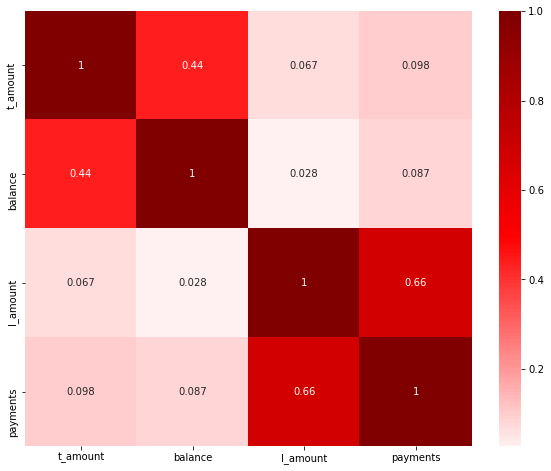

In [104]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix,
           cmap='seismic',
           center=0,
           annot=True,
           );

Note
* some high correlations between my features: Come back after first model validation and maybe drop highly correlated features

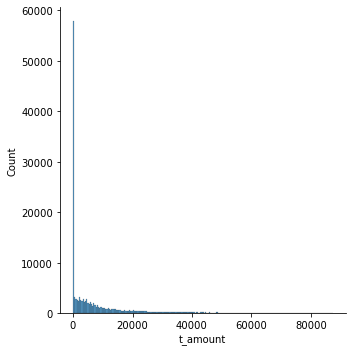

In [105]:
sns.displot(data['t_amount'])

In [106]:
data['t_amount'].describe()

count    147748.000000
mean       8022.366812
std       11980.002505
min           0.000000
25%         134.800000
50%        2700.000000
75%       10721.000000
max       87300.000000
Name: t_amount, dtype: float64

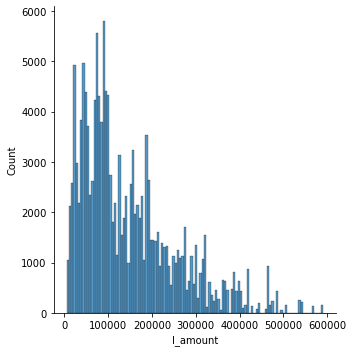

In [107]:
#fig, ax = plt.subplots(figsize=(12,8))
sns.displot(data['l_amount'])

In [108]:
data['l_amount'].describe()

count    147748.000000
mean     145810.456913
std      109587.181764
min        4980.000000
25%       64860.000000
50%      110736.000000
75%      200976.000000
max      590820.000000
Name: l_amount, dtype: float64

In [109]:
import numpy as np
from sklearn.preprocessing import Normalizer

X = data.select_dtypes(include = np.number)

In [110]:
X.head()

,t_amount,balance,l_amount,payments
62,44749.0,45549.0,79608.0,3317.0
63,1000.0,1000.0,52788.0,4399.0
69,1100.0,1100.0,21924.0,609.0
75,700.0,700.0,23052.0,1921.0
96,900.0,900.0,41904.0,3492.0


In [111]:
transformer = Normalizer()
transformer.fit(X)
x_normalized = transformer.transform(X)

In [112]:
x = pd.DataFrame(x_normalized, columns=X.columns)

In [113]:
x

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007
...,...,...,...,...
147743,0.000253,0.063358,0.997852,0.016631
147744,0.000426,0.096119,0.995232,0.016587
147745,0.000481,0.113176,0.993437,0.016557
147746,0.000706,0.152565,0.988156,0.016469


In [114]:
data['duration'].value_counts()

24.0    32595
12.0    31278
60.0    29797
48.0    27330
36.0    26748
Name: duration, dtype: int64

In [115]:
x

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007
...,...,...,...,...
147743,0.000253,0.063358,0.997852,0.016631
147744,0.000426,0.096119,0.995232,0.016587
147745,0.000481,0.113176,0.993437,0.016557
147746,0.000706,0.152565,0.988156,0.016469


In [116]:
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
62,PRIJEM,prevod,44749.0,45549.0,unknown,79608.0,24,3317.0,A
63,PRIJEM,vklad,1000.0,1000.0,unknown,52788.0,12,4399.0,A
69,PRIJEM,vklad,1100.0,1100.0,unknown,21924.0,36,609.0,A
75,PRIJEM,vklad,700.0,700.0,unknown,23052.0,12,1921.0,A
96,PRIJEM,vklad,900.0,900.0,unknown,41904.0,12,3492.0,A
...,...,...,...,...,...,...,...,...,...
867954,PRIJEM,unknown,67.9,17036.9,UROK,268320.0,60,4472.0,C
867981,PRIJEM,unknown,187.2,42249.6,UROK,437460.0,60,7291.0,C
867986,PRIJEM,unknown,132.0,31046.4,UROK,272520.0,60,4542.0,C
867997,PRIJEM,unknown,271.6,58694.2,UROK,380160.0,60,6336.0,C


In [117]:
cat = data.select_dtypes(include = np.object)

In [118]:
cat

,type,operation,k_symbol,duration,status
62,PRIJEM,prevod,unknown,24,A
63,PRIJEM,vklad,unknown,12,A
69,PRIJEM,vklad,unknown,36,A
75,PRIJEM,vklad,unknown,12,A
96,PRIJEM,vklad,unknown,12,A
...,...,...,...,...,...
867954,PRIJEM,unknown,UROK,60,C
867981,PRIJEM,unknown,UROK,60,C
867986,PRIJEM,unknown,UROK,60,C
867997,PRIJEM,unknown,UROK,60,C


In [119]:
cat = cat.drop(['status'], axis=1)

In [120]:
cat.head()

,type,operation,k_symbol,duration
62,PRIJEM,prevod,unknown,24
63,PRIJEM,vklad,unknown,12
69,PRIJEM,vklad,unknown,36
75,PRIJEM,vklad,unknown,12
96,PRIJEM,vklad,unknown,12


In [133]:
categorical = pd.get_dummies(cat,
               drop_first=True,
               columns=['type', 'operation', 'k_symbol', 'duration'])

# Modelling

In [136]:
x.head()

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007


In [138]:
categorical.head()

,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_unknown,duration_24.0,duration_36.0,duration_48.0,duration_60.0
62,0,0,0,0,0,0,0,0,1,1,0,0,0
63,0,0,0,1,0,0,0,0,1,0,0,0,0
69,0,0,0,1,0,0,0,0,1,0,1,0,0
75,0,0,0,1,0,0,0,0,1,0,0,0,0
96,0,0,0,1,0,0,0,0,1,0,0,0,0


In [140]:
y = data['status']

In [144]:
len(x), len(y), len(data)

(147748, 147748, 147748)

In [ ]:
X = np.concatenate 

### Explanation for dummie variables

In [125]:
import random
gender_lst = ['M', 'F']

In [126]:
df_example = pd.DataFrame({'gender':[random.choice(gender_lst) for i in range(20)]})

In [131]:
pd.get_dummies(df_example, columns=['gender'], drop_first=True)

,gender_M
0,1
1,0
2,1
3,0
4,0
5,1
6,0
7,1
8,1
9,0


Recall the meaning of A, B, C, D

* **A**: contract finished, no problems (we have a lot of them)
* **B**: contract finished, loan not payed
* **C**: running contract, OK so far (we have a lot of them)
* **D**: running contract, client in debt